In [70]:
import juliacall  # must preceed any torch imports to avoid segfault.
import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal
from copy import copy

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from chirho_diffeqpy import DiffEqPyMockClosureCapable, MockDynamicsClosureMixin, ATempParams, PureDynamics
from chirho_diffeqpy.lang_interop import julianumpy
from chirho_diffeqpy.handlers.mock_closure import _ArrayLike

SOLVER = DiffEqPyMockClosureCapable
# SOLVER = TorchDiffEq

pyro.settings.set(module_local_params=True)

sns.set_style("white")

smoke_test = ('CI' in os.environ)
num_steps = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 500

In [50]:
def pure_sir_dynamics(state: State, atemp_params: ATempParams):
    beta = atemp_params["beta"]
    gamma = atemp_params["gamma"]
    
    dX = dict()
    dX["S"] = -beta * state["S"] * state["I"]
    dX["I"] = beta * state["S"] * state["I"] - gamma * state["I"]
    dX["R"] = gamma * state["I"]
    
    return dX

class ClosureSIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma
        self._atemp_params = dict(
            beta=beta,
            gamma=gamma,
        )

    def forward(self, state: State):
        return pure_sir_dynamics(state, self._atemp_params)


class PureSIRDynamics(ClosureSIRDynamics, MockDynamicsClosureMixin):
    
    @property
    def atemp_params(self):
        return self._atemp_params

    # noinspection PyMethodOverriding
    def forward(self, state: State, atemp_params: ATempParams):
        return pure_sir_dynamics(state, atemp_params)
    
SIRDynamics = PureSIRDynamics if SOLVER is DiffEqPyMockClosureCapable else ClosureSIRDynamics
    
def sir_observation_model(X: State[torch.Tensor]) -> None:
    # We don't observe the number of susceptible individuals directly.
    pyro.sample("I_obs", dist.Poisson(X["I"] + 1.).to_event(1))  # noisy number of infected actually observed
    pyro.sample("R_obs", dist.Poisson(X["R"] + 1.).to_event(1))  # noisy number of recovered actually observed
    
def sir_prior():
    return dict(
        beta=pyro.sample("beta", dist.Uniform(0, 1)),
        gamma=pyro.sample("gamma", dist.Uniform(0, 1)),
    )

def simulated_bayesian_sir(init_state, start_time, logging_times, base_model=SIRDynamics) -> State[torch.Tensor]:
    sir = base_model(**sir_prior())
    with SOLVER(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [51]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(3.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SIR model
beta_true = torch.tensor(0.03)
gamma_true = torch.tensor(0.5)
sir_true = SIRDynamics(beta_true, gamma_true)
with SOLVER(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

obs_start_time = torch.tensor(0.5) # Measurements start 0.5 month into the pandemic
obs_sample_rate = torch.tensor(1/30) # Take measurements one per day
obs_end_time = torch.tensor(1.0) # Measurements end after 1st month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with SOLVER(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sir_observation_model(sir_obs_traj)

sir_data = dict(**{k:tr.trace.nodes[k]["value"] for k in ["I_obs", "R_obs"]})

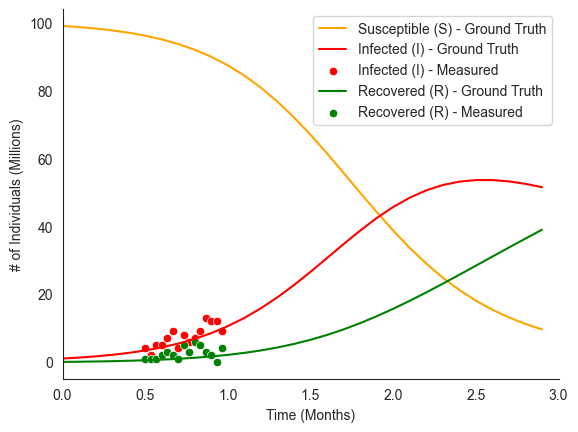

In [52]:
sns.lineplot(
    x=logging_times, y=sir_true_traj["S"], label="Susceptible (S) - Ground Truth", color="orange"
)
sns.lineplot(x=logging_times, y=sir_true_traj["I"], label="Infected (I) - Ground Truth", color="red")
sns.scatterplot(x=obs_logging_times, y=sir_data["I_obs"], label="Infected (I) - Measured", color="red")
sns.lineplot(x=logging_times, y=sir_true_traj["R"], label="Recovered (R) - Ground Truth", color="green")
sns.scatterplot(x=obs_logging_times, y=sir_data["R_obs"], label="Recovered (R) - Measured", color="green")
sns.despine()

plt.xlim(start_time, end_time)
plt.xlabel("Time (Months)")
plt.ylabel("# of Individuals (Millions)")
plt.legend(loc="upper right")

In [53]:
#

In [54]:
prior_predictive = Predictive(simulated_bayesian_sir, num_samples=num_samples)
sir_prior_samples = prior_predictive(init_state, start_time, logging_times)

In [55]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label="Posterior Mean"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label=mean_label,
        ax=ax,
    )
    # 95% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.025, dim=0),
        torch.quantile(state_pred, 0.975, dim=0),
        alpha=0.2,
        color=color,
        label="95% Credible Interval",
    )

    ax.set_xlabel("Time (Months)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(
        test_end_time, color="black", linestyle=":"
    )


def SIR_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=obs_start_time,
    test_end_time=obs_end_time,
    mean_label="Posterior Mean",
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label=mean_label)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

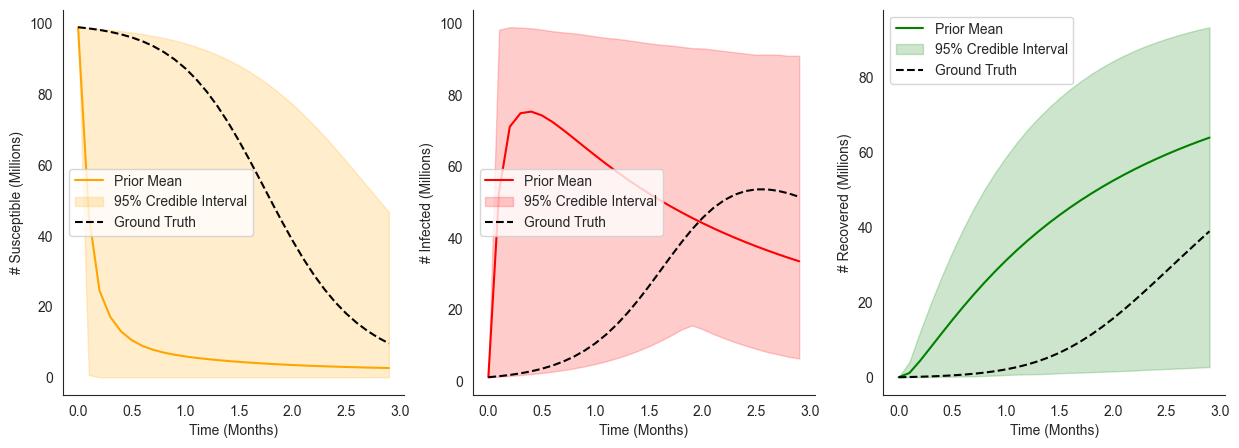

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
SIR_plot(
    logging_times,
    sir_prior_samples["S"],
    sir_true_traj["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIR_plot(
    logging_times,
    sir_prior_samples["I"],
    sir_true_traj["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIR_plot(
    logging_times,
    sir_prior_samples["R"],
    sir_true_traj["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

In [ ]:
#

In [59]:
def conditioned_sir(obs_times, data, init_state, start_time, base_model=SIRDynamics) -> None:
    sir = base_model(**sir_prior())
    obs = condition(data=data)(sir_observation_model)
    with SOLVER(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, num_steps=num_steps, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [60]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 1108.0744
[iteration 0100] loss: 1095.2498
[iteration 0200] loss: 63.2166
[iteration 0300] loss: 156.5409
[iteration 0400] loss: 68.1542
[iteration 0500] loss: 70.6648
[iteration 0600] loss: 69.9515
[iteration 0700] loss: 64.0889
[iteration 0800] loss: 68.5763
[iteration 0900] loss: 65.9370
[iteration 1000] loss: 67.5182


In [ ]:
#

In [62]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_bayesian_sir, guide=sir_guide, num_samples=num_samples)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

Text(0.5, 0, 'Gamma')

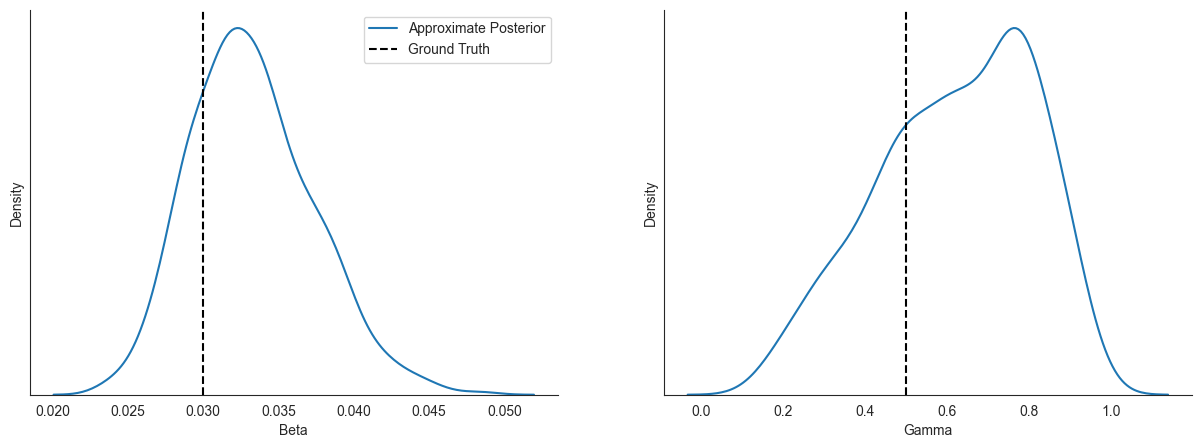

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(sir_posterior_samples["beta"], label="Approximate Posterior", ax=ax[0])
ax[0].axvline(beta_true, color="black", label="Ground Truth", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Beta")

sns.kdeplot(sir_posterior_samples["gamma"], ax=ax[1])
plt.axvline(gamma_true, color="black", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].set_xlabel("Gamma")

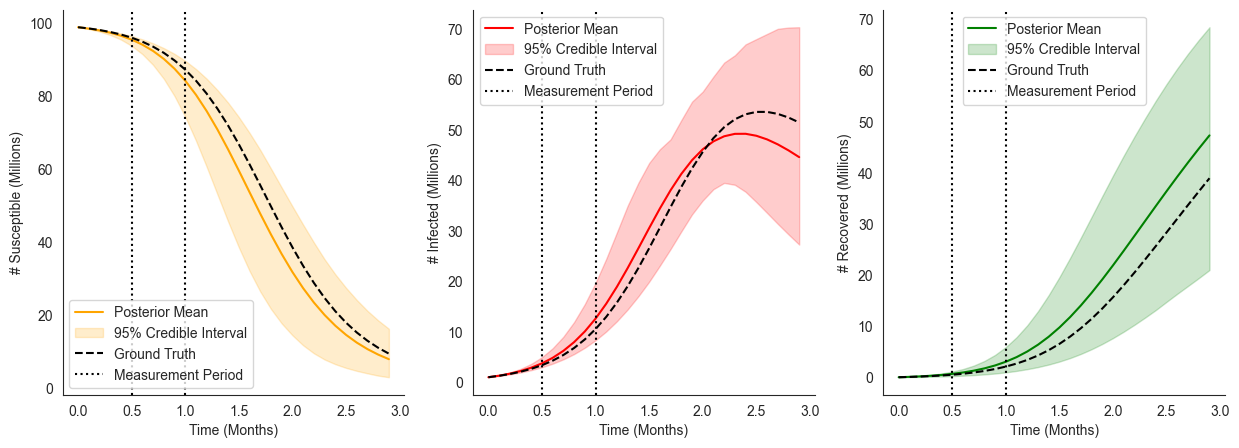

In [64]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    sir_posterior_samples["S"],
    sir_true_traj["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
)
SIR_plot(
    logging_times,
    sir_posterior_samples["I"],
    sir_true_traj["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
)
SIR_plot(
    logging_times,
    sir_posterior_samples["R"],
    sir_true_traj["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
)

In [72]:
def pure_sir_dynamics_lockdown(state: State, atemp_params: ATempParams):
    lockdown_strength = state["l"]
    beta0 = atemp_params["beta"]
    
    copied_atemp_params = copy(atemp_params)
    copied_atemp_params["beta"] = (1. - lockdown_strength) * beta0
    
    dX = pure_sir_dynamics(state, copied_atemp_params)
    # no dynamics for the lockdown strength unless intervened
    dX["l"] = lockdown_strength * 0.0
    
    return dX

class ClosureSIRDynamicsLockdown(ClosureSIRDynamics):
    def forward(self, X: State[torch.Tensor]):
        return pure_sir_dynamics_lockdown(X, self._atemp_params)

class PureSIRDynamicsLockdown(PureSIRDynamics):
    # noinspection PyMethodOverriding
    def forward(self, X: State[torch.Tensor], atemp_params: ATempParams):
        return pure_sir_dynamics_lockdown(X, atemp_params)
    
SIRDynamicsLockdown = PureSIRDynamicsLockdown if SOLVER is DiffEqPyMockClosureCapable else ClosureSIRDynamicsLockdown

init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

In [ ]:
#

In [73]:
def intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, start_time, logging_times) -> State[torch.Tensor]:
    sir = SIRDynamicsLockdown(**sir_prior())
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with SOLVER():
            with StaticIntervention(time=lockdown_start, intervention=dict(l=lockdown_strength)):
                with StaticIntervention(time=lockdown_end, intervention=dict(l=torch.tensor(0.0))):
                    simulate(sir, init_state, start_time, logging_times[-1])
                    
    return lt.trajectory

In [74]:
lockdown_start = torch.tensor(1.0)
lockdown_end = torch.tensor(2.0)
lockdown_strength = torch.tensor(0.75)

true_intervened_sir = pyro.condition(intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_intervened_trajectory = true_intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

intervened_sir_predictive = Predictive(intervened_sir, guide=sir_guide, num_samples=num_samples)
intervened_sir_posterior_samples = intervened_sir_predictive(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

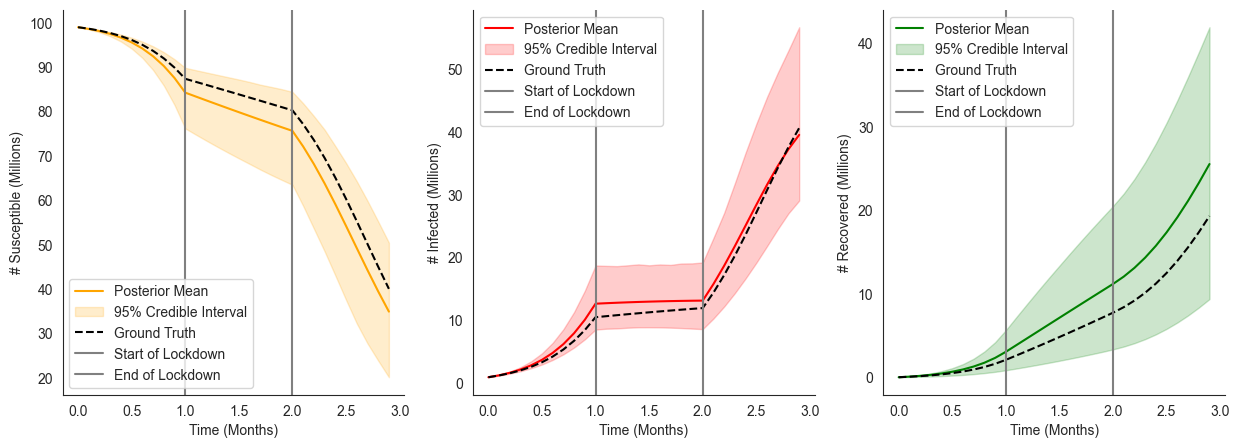

In [75]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="End of Lockdown")
    a.legend()